In [3]:

import numpy as np
import cv2
import matplotlib.pyplot as plt
from scipy.ndimage import maximum_filter
from skimage.feature import peak_local_max
from skimage.filters import gaussian
from ultralytics import SAM
import os
import glob


In [53]:
# Usage
scan_dir = "merged_scan_2"
image_dir = "419_perspective"


anomaly_mask = np.load(f"results/anomaly_masks/exp_train400_coreset0.3/{scan_dir}_{image_dir}_mask.npy")
original_image_path = f"masonry_dataset/wall/test/defect/{scan_dir}_{image_dir}.png"
original_point_path = f"bucket/analysis-pipeline-data/National_Highways/Wheatley_Tunnel/data_intermediate/figures/dataset_depth_image/20250617/{scan_dir}/{image_dir}.npz"
original_image = cv2.imread(original_image_path)


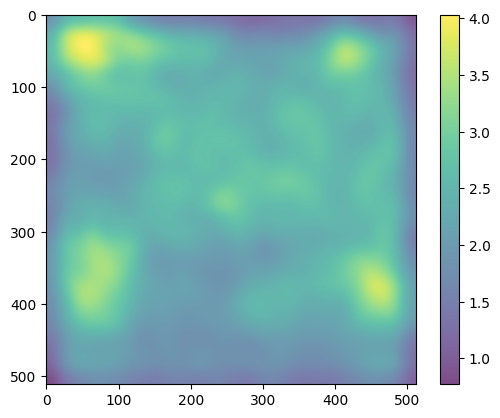

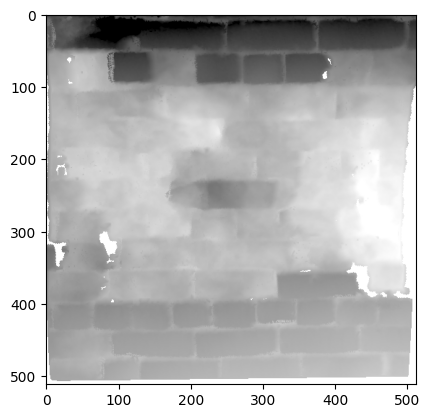

In [54]:
plt.imshow(anomaly_mask, alpha=0.7)
plt.colorbar()
plt.show()

# Show contour lines at different anomaly score levels
plt.imshow(original_image)  # Your background image
plt.show()


In [31]:
def get_contour_bounding_boxes(contours, padding=10):
    """
    Extract bounding boxes from matplotlib contours for SAM prompts

    Args:
        contours: matplotlib contour object from plt.contour()
        padding: pixels to add around each bounding box

    Returns:
        list: List of bounding boxes in [x1, y1, x2, y2] format for SAM
    """
    bounding_boxes = []

    for level_idx in range(len(contours.levels)):
        level_paths = contours.collections[level_idx].get_paths()

        for path in level_paths:
            if len(path.vertices) < 3:
                continue

            vertices = path.vertices

            # Get min/max coordinates
            x_min = vertices[:, 0].min()
            x_max = vertices[:, 0].max()
            y_min = vertices[:, 1].min()
            y_max = vertices[:, 1].max()

            # Add padding
            x1 = max(0, int(x_min - padding))
            y1 = max(0, int(y_min - padding))
            x2 = int(x_max + padding)
            y2 = int(y_max + padding)

            # SAM format: [x1, y1, x2, y2]
            bbox = [x1, y1, x2, y2]
            bounding_boxes.append(bbox)

    return bounding_boxes

In [7]:
def merge_contained_bounding_boxes(bounding_boxes):
    """
    Remove bounding boxes that are fully contained within other bounding boxes.
    Returns only the 'parent' bounding boxes.

    Args:
        bounding_boxes: List of bounding boxes in [x1, y1, x2, y2] format

    Returns:
        List of parent bounding boxes (those that contain others or are not contained)
    """
    if not bounding_boxes:
        return []

    def is_contained(bbox_a, bbox_b):
        """Check if bbox_a is fully contained within bbox_b"""
        x1_a, y1_a, x2_a, y2_a = bbox_a
        x1_b, y1_b, x2_b, y2_b = bbox_b

        return (x1_b <= x1_a and y1_b <= y1_a and
                x2_a <= x2_b and y2_a <= y2_b)

    parent_boxes = []

    for i, bbox_candidate in enumerate(bounding_boxes):
        is_child = False

        # Check if this bounding box is contained within any other
        for j, bbox_other in enumerate(bounding_boxes):
            if i != j and is_contained(bbox_candidate, bbox_other):
                is_child = True
                break

        # If not contained within any other box, it's a parent
        if not is_child:
            parent_boxes.append(bbox_candidate)

    return parent_boxes


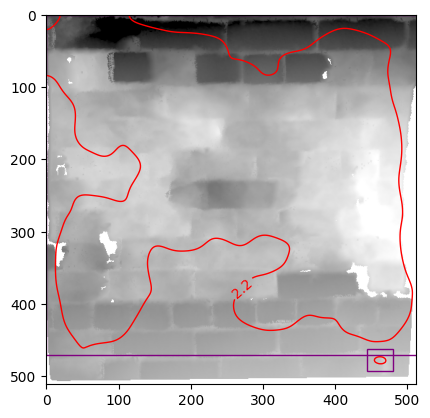

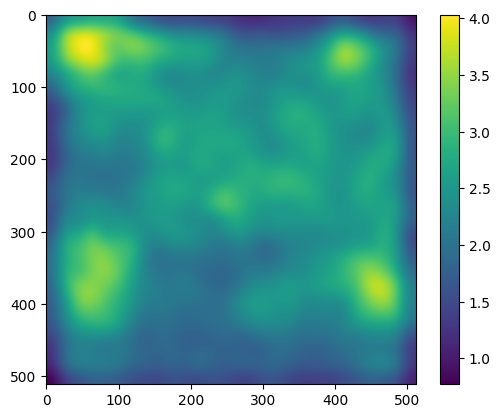

In [55]:
import numpy as np
import cv2
from matplotlib.path import Path
import copy

# Get contours and extract geometry before visualisation
contours = plt.contour(anomaly_mask, levels=[2.2], colors='red', linewidths=1)
bounding_boxes = get_contour_bounding_boxes(contours, padding=10)

bounding_boxes = merge_contained_bounding_boxes(bounding_boxes)

# Visualize
plt.imshow(original_image)
plt.clabel(contours, inline=True)  # Add labels showing the levels

for i, bbox in enumerate(bounding_boxes):
    x1, y1, x2, y2 = bbox
    width = x2 - x1
    height = y2 - y1
    rect = plt.Rectangle((x1, y1), width, height,
                        fill=False, color='purple', linewidth=1)
    plt.gca().add_patch(rect)

plt.show()

plt.imshow(anomaly_mask)
plt.colorbar()
plt.show()



In [9]:
from ultralytics import SAM
import cv2
import numpy as np
import matplotlib.pyplot as plt

sam_model = SAM('sam2.1_l.pt')


0: 512x512 1 0, 1 1, 68.7ms
Speed: 1.6ms preprocess, 68.7ms inference, 1.0ms postprocess per image at shape (1, 3, 512, 512)
Results saved to /home/tom_hill_joltsynsor_com/patchcore-inspection/runs/segment/predict24


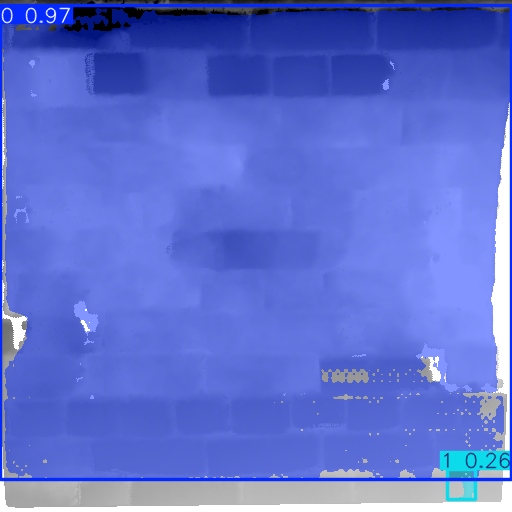

In [65]:
def run_sam_on_bboxes(image_path, bboxes):
    """Simple function to run SAM on hotspot points"""

    # Load image
    image = cv2.imread(image_path)
    image_rgb = cv2.cvtColor(image, cv2.COLOR_BGR2RGB)

    # Convert points to numpy array
    points = np.array(bboxes)

    labels = np.ones(len(bboxes))


    # Run SAM
    results = sam_model(image_rgb, bboxes=bboxes, labels=labels, imgsz=512, save=True)

    return image_rgb, results

_, results = run_sam_on_bboxes(original_image_path, bounding_boxes)
results[0].show()

polygons = results[0].masks.xy

polygons = [poly.cpu().numpy() if hasattr(poly, 'cpu') else poly for poly in polygons]




image 1/1 /home/tom_hill_joltsynsor_com/patchcore-inspection/masonry_dataset/wall/test/defect/merged_scan_2_419_perspective.png: 1024x1024 1 0, 1 1, 1 2, 1 3, 1 4, 1 5, 1 6, 1 7, 1 8, 1 9, 1 10, 1 11, 1 12, 1 13, 1 14, 1 15, 1 16, 1 17, 1 18, 1 19, 1 20, 1 21, 1 22, 1 23, 7245.9ms
Speed: 5.5ms preprocess, 7245.9ms inference, 1.2ms postprocess per image at shape (1, 3, 1024, 1024)


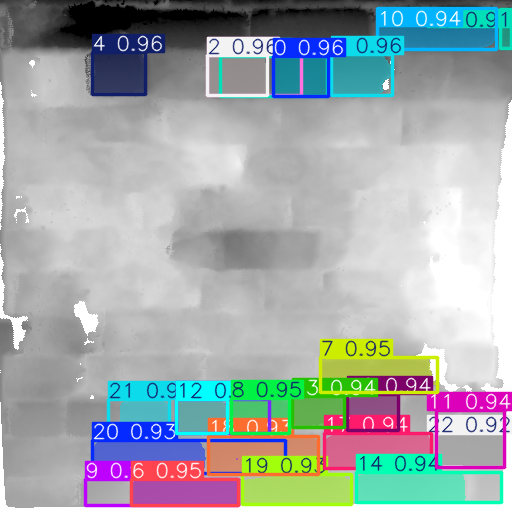

In [57]:
segment_everything = SAM('sam2.1_l.pt')

results = segment_everything(original_image_path)

results[0].show()



In [58]:
polygons = results[0].masks.xy

polygons = [poly.cpu().numpy() if hasattr(poly, 'cpu') else poly for poly in polygons]


print(len(polygons))

print(polygons[2].shape)

24
(44, 2)


(512, 512)


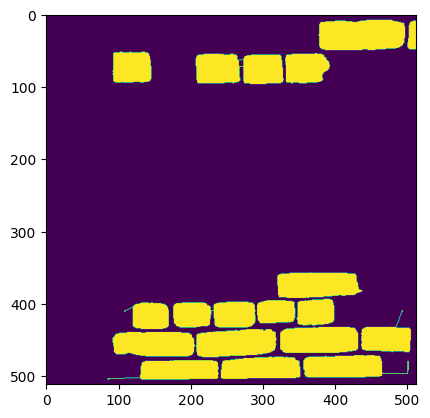

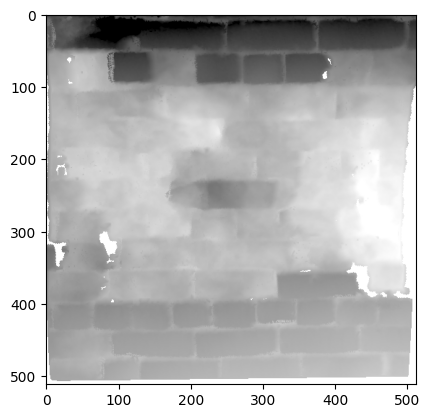

In [59]:
def create_mask_from_polygons(polygons, image_shape):
    """
    Create a binary mask from polygon coordinates.

    Args:
        polygons: List of polygon arrays, each with shape (N, 2)
        image_shape: Tuple (height, width) of the target image

    Returns:
        numpy.ndarray: Binary mask where 1 = inside polygons, 0 = outside
    """
    # Create empty mask
    mask = np.zeros(image_shape[:2], dtype=np.uint8)

    # Fill polygons
    for polygon in polygons:
        # Convert to integer coordinates
        polygon = polygon.astype(np.int32)
        # Fill the polygon
        cv2.fillPoly(mask, [polygon], 1)

    return mask

# Create mask using your existing image
mask = create_mask_from_polygons(polygons, original_image.shape)

print(mask.shape)

plt.imshow(mask)
plt.show()

plt.imshow(original_image)
plt.show()



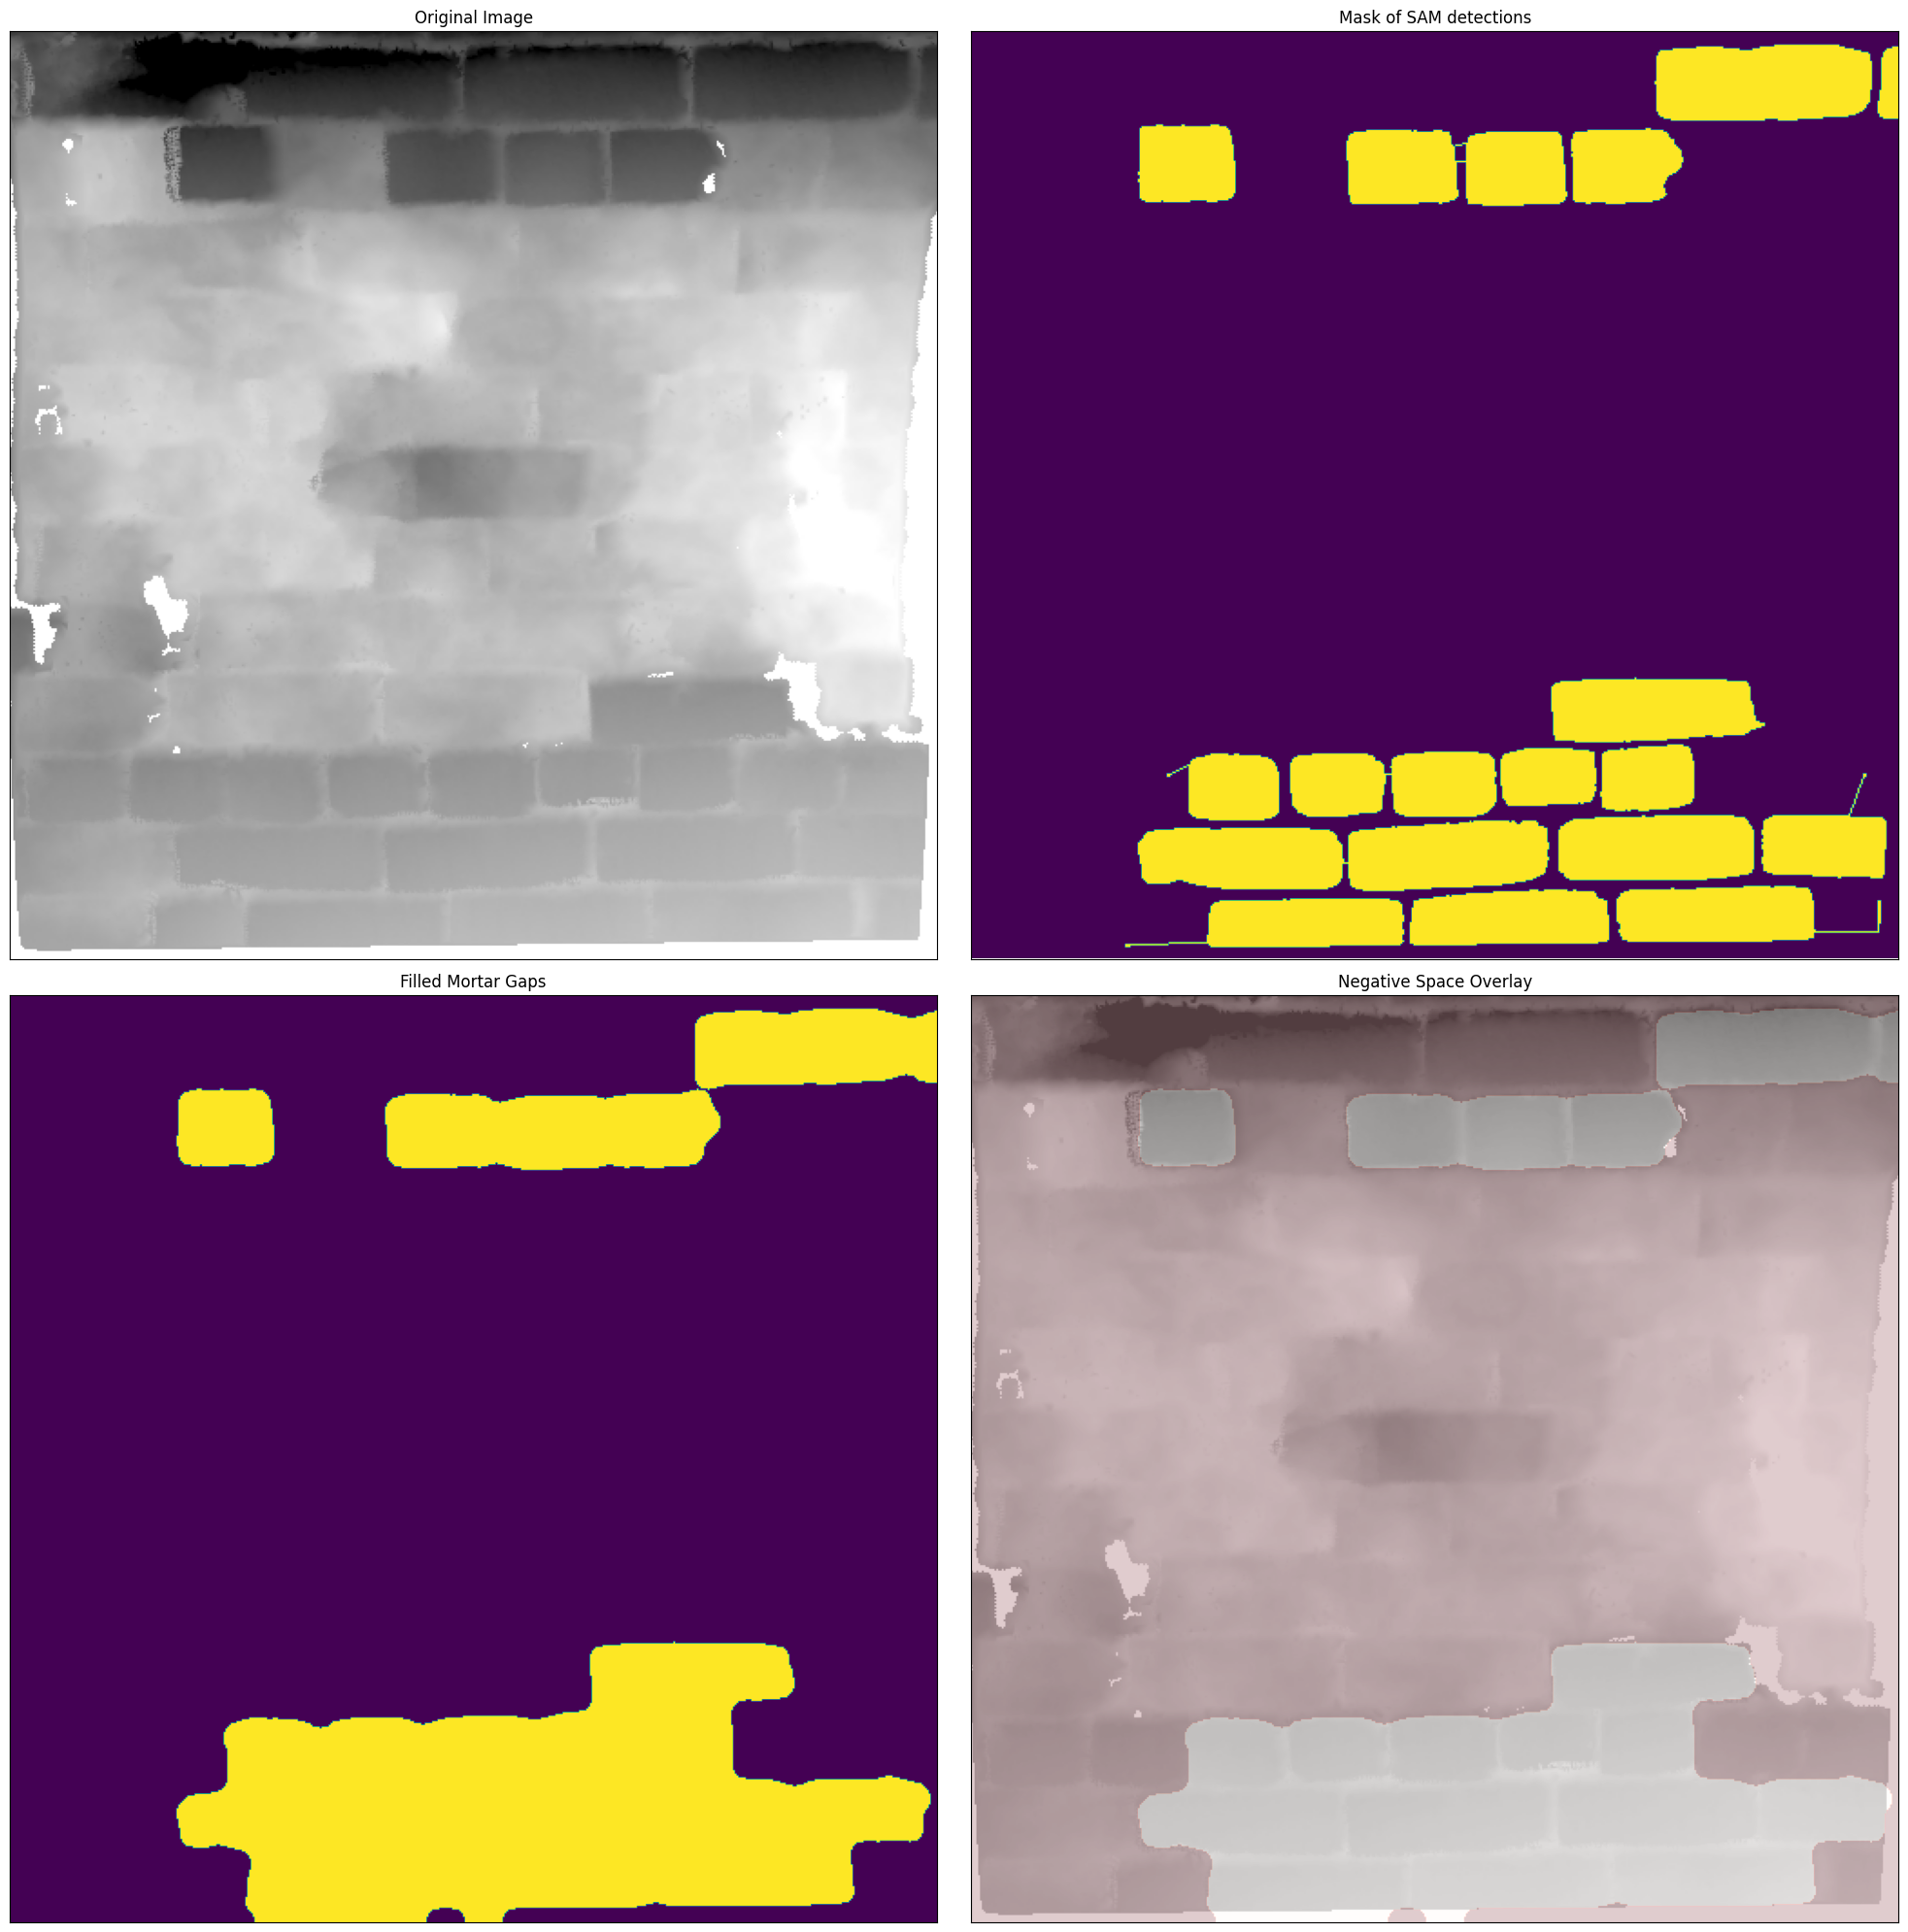

In [64]:
import cv2
import numpy as np
from scipy import ndimage

def fill_mortar_gaps(mask, kernel_size=5, iterations=1):
    """
    Fill in mortar gaps between bricks using morphological closing.

    Args:
        mask: Binary mask (0 = background/mortar, 1 = bricks)
        kernel_size: Size of morphological kernel (larger = fills bigger gaps)
        iterations: Number of iterations (more = more aggressive filling)

    Returns:
        numpy.ndarray: Processed mask with mortar gaps filled
    """
    # Create morphological kernel
    kernel = cv2.getStructuringElement(cv2.MORPH_ELLIPSE, (kernel_size, kernel_size))

    # Apply morphological closing to fill gaps
    filled_mask = cv2.morphologyEx(mask.astype(np.uint8), cv2.MORPH_CLOSE, kernel, iterations=iterations)

    return filled_mask

def fill_mortar_gaps_adaptive(mask, min_gap_size=3, max_gap_size=15):
    """
    Adaptive mortar gap filling - tries different kernel sizes.

    Args:
        mask: Binary mask
        min_gap_size: Minimum gap size to fill
        max_gap_size: Maximum gap size to fill

    Returns:
        numpy.ndarray: Processed mask with mortar gaps filled
    """
    result = mask.copy().astype(np.uint8)

    # Apply multiple passes with increasing kernel sizes
    for kernel_size in range(min_gap_size, max_gap_size + 1, 2):
        kernel = cv2.getStructuringElement(cv2.MORPH_ELLIPSE, (kernel_size, kernel_size))
        result = cv2.morphologyEx(result, cv2.MORPH_CLOSE, kernel, iterations=1)

    return result

def fill_mortar_gaps_conservative(mask, kernel_size=3):
    """
    Conservative gap filling that preserves larger negative spaces.

    Args:
        mask: Binary mask
        kernel_size: Size of morphological kernel

    Returns:
        numpy.ndarray: Processed mask
    """
    # First, apply closing to fill small gaps
    kernel = cv2.getStructuringElement(cv2.MORPH_ELLIPSE, (kernel_size, kernel_size))
    filled = cv2.morphologyEx(mask.astype(np.uint8), cv2.MORPH_CLOSE, kernel)

    # Then apply opening to separate any incorrectly merged regions
    opened = cv2.morphologyEx(filled, cv2.MORPH_OPEN, kernel)

    return opened

filled_mask = fill_mortar_gaps_adaptive(mask, min_gap_size=1, max_gap_size=15)
# Now get the negative space (inverted mask)
negative_space_mask = 1 - filled_mask

filled_mask = 1 - fill_mortar_gaps_adaptive(negative_space_mask, min_gap_size=1, max_gap_size=15)

negative_space_mask = 1 - filled_mask
# Visualize the results
import matplotlib.pyplot as plt

fig, axes = plt.subplots(2, 2, figsize=(20, 20))

# Original image (convert BGR to RGB for proper display)
axes[0, 0].imshow(cv2.cvtColor(original_image, cv2.COLOR_BGR2RGB))
axes[0, 0].set_title('Original Image')

# Mask of SAM detections
axes[0, 1].imshow(mask, cmap='viridis')
axes[0, 1].set_title('Mask of SAM detections')

# Filled mortar gaps
axes[1, 0].imshow(filled_mask, cmap='viridis')
axes[1, 0].set_title('Filled Mortar Gaps')

# Negative space overlay
axes[1, 1].imshow(cv2.cvtColor(original_image, cv2.COLOR_BGR2RGB), alpha=0.7)
axes[1, 1].imshow(negative_space_mask, cmap='Reds', alpha=0.2)
axes[1, 1].set_title('Negative Space Overlay')

# Remove axis ticks for cleaner look
for ax in axes.flat:
    ax.set_xticks([])
    ax.set_yticks([])

plt.tight_layout()
plt.show()